Name: Puan Abidah Nitisara  
Nim: 201401009  


---

This model is trained with balanced data across classes using the SMOTE technique and the DenseNet121 architecture.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from glob import glob
from PIL import Image
import shutil
import matplotlib.pyplot as plt
import warnings

from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from mlxtend.plotting import plot_confusion_matrix

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [ ]:
base_dir = '/content/drive/MyDrive/skin-cancer-mnist-ham10000'

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

In [ ]:
imageid_path_dict

{'ISIC_0033304': '/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033304.jpg',
 'ISIC_0033294': '/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033294.jpg',
 'ISIC_0033363': '/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033363.jpg',
 'ISIC_0033373': '/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033373.jpg',
 'ISIC_0033356': '/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033356.jpg',
 'ISIC_0033387': '/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033387.jpg',
 'ISIC_0033364': '/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033364.jpg',
 'ISIC_0033355': '/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033355.jpg',
 'ISIC_0033357': '/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033357.jpg',
 'ISIC_003

In [ ]:
size = (120, 120)

df['path'] = df['image_id'].map(imageid_path_dict.get)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size))/ 255)

In [ ]:
df = df[['dx', 'image']]

In [ ]:
df.head()

,dx,image
0,bkl,"[[[0.7411764705882353, 0.596078431372549, 0.76..."
1,bkl,"[[[0.09411764705882353, 0.050980392156862744, ..."
2,bkl,"[[[0.7333333333333333, 0.4980392156862745, 0.5..."
3,bkl,"[[[0.09411764705882353, 0.043137254901960784, ..."
4,bkl,"[[[0.5098039215686274, 0.34509803921568627, 0...."


In [ ]:
df

,dx,image
0,bkl,"[[[0.7411764705882353, 0.596078431372549, 0.76..."
1,bkl,"[[[0.09411764705882353, 0.050980392156862744, ..."
2,bkl,"[[[0.7333333333333333, 0.4980392156862745, 0.5..."
3,bkl,"[[[0.09411764705882353, 0.043137254901960784, ..."
4,bkl,"[[[0.5098039215686274, 0.34509803921568627, 0...."
...,...,...
10010,akiec,"[[[0.5294117647058824, 0.4588235294117647, 0.4..."
10011,akiec,"[[[0.0196078431372549, 0.023529411764705882, 0..."
10012,akiec,"[[[0.4235294117647059, 0.3843137254901961, 0.3..."
10013,akiec,"[[[0.615686274509804, 0.47058823529411764, 0.5..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dx      10015 non-null  object
 1   image   10015 non-null  object
dtypes: object(2)
memory usage: 156.6+ KB


In [ ]:
df['image'].map(lambda x: x.shape).value_counts()

image
(120, 120, 3)    10015
Name: count, dtype: int64

In [ ]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [ ]:
counts = pd.DataFrame(df['dx'].value_counts()).reset_index()
counts

,dx,count
0,nv,6705
1,mel,1113
2,bkl,1099
3,bcc,514
4,akiec,327
5,vasc,142
6,df,115


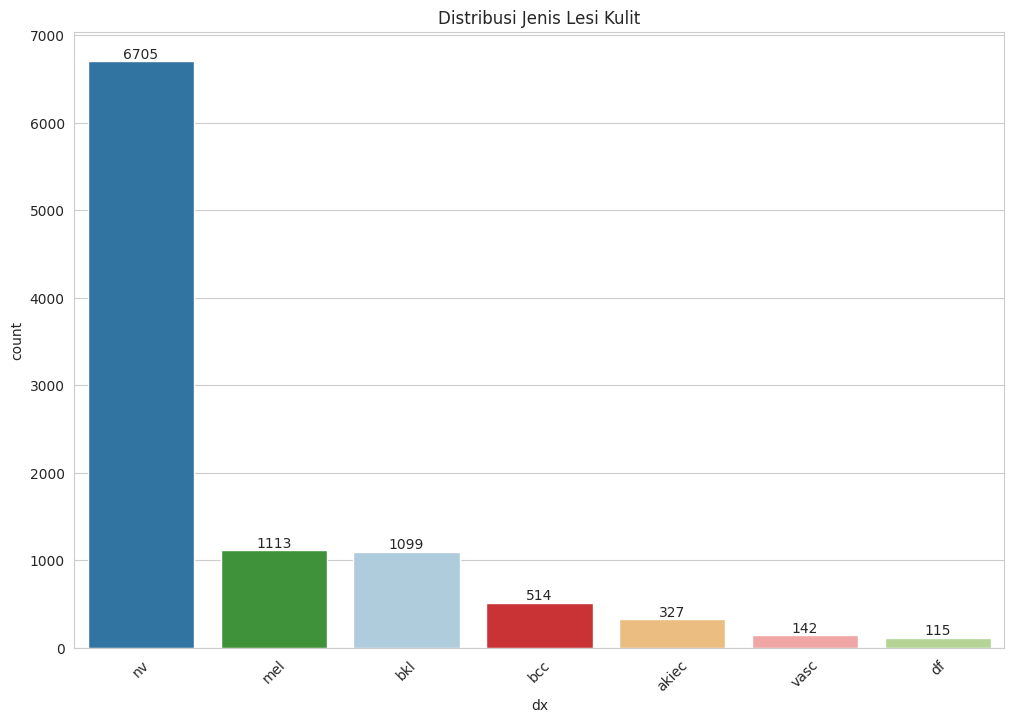

In [ ]:
# visualize the distribution of images
import seaborn as sns

sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx', data=df, order=df['dx'].value_counts().index, hue='dx', palette='Paired', legend=False)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Distribusi Jenis Lesi Kulit')
plt.xticks(rotation=45)
plt.show()

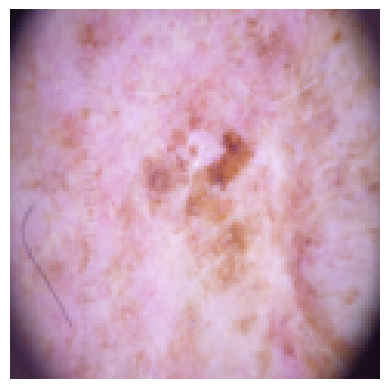

In [ ]:
arr = df.iloc[1]['image']
#Image.fromarray(arr)
plt.imshow(arr)
plt.axis('off')
plt.show()

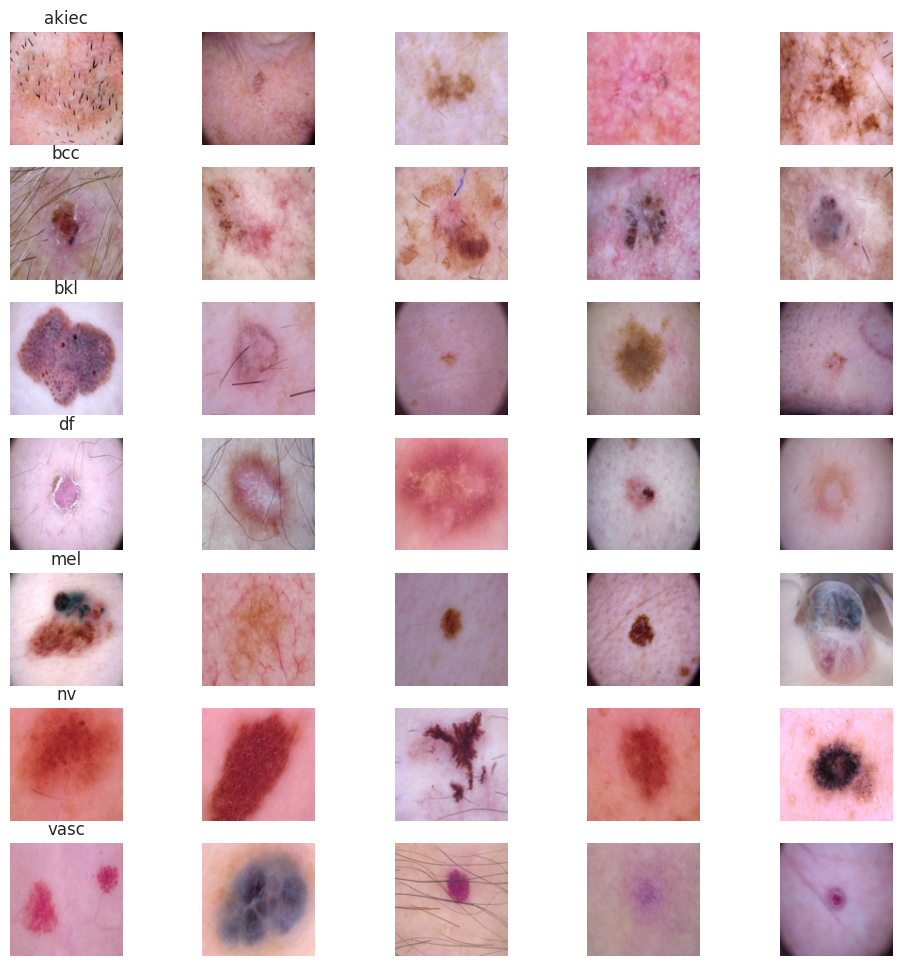

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (12,12))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [ ]:
labelEncoder = LabelEncoder()
df['label'] = labelEncoder.fit_transform(df['dx'])

In [ ]:
df['label']

0        2
1        2
2        2
3        2
4        2
        ..
10010    0
10011    0
10012    0
10013    0
10014    4
Name: label, Length: 10015, dtype: int64

In [ ]:
x = np.asarray(df['image'].to_list())
y = df['label']

In [ ]:
x

array([[[[0.74117647, 0.59607843, 0.76078431],
         [0.75294118, 0.61176471, 0.77647059],
         [0.74901961, 0.60392157, 0.76862745],
         ...,
         [0.75686275, 0.58823529, 0.62352941],
         [0.76078431, 0.6       , 0.65098039],
         [0.76470588, 0.61568627, 0.6627451 ]],

        [[0.74901961, 0.58823529, 0.75294118],
         [0.75294118, 0.59215686, 0.75294118],
         [0.75294118, 0.59607843, 0.75294118],
         ...,
         [0.74901961, 0.58431373, 0.60784314],
         [0.76078431, 0.6       , 0.64705882],
         [0.76862745, 0.61568627, 0.6627451 ]],

        [[0.74509804, 0.56862745, 0.7372549 ],
         [0.74509804, 0.57254902, 0.72156863],
         [0.75294118, 0.6       , 0.74117647],
         ...,
         [0.75686275, 0.58823529, 0.60784314],
         [0.76078431, 0.58823529, 0.63921569],
         [0.75686275, 0.6       , 0.63921569]],

        ...,

        [[0.64705882, 0.51764706, 0.64705882],
         [0.66666667, 0.53333333, 0.65882353]

In [ ]:
# Flatten each image into a 1D array
x_flat = np.asarray([img.flatten() for img in x])

In [ ]:
x_flat

array([[0.74117647, 0.59607843, 0.76078431, ..., 0.69803922, 0.57647059,
        0.64313725],
       [0.09411765, 0.05098039, 0.08627451, ..., 0.09019608, 0.05098039,
        0.08627451],
       [0.73333333, 0.49803922, 0.53333333, ..., 0.41176471, 0.25490196,
        0.2627451 ],
       ...,
       [0.42352941, 0.38431373, 0.39607843, ..., 0.64313725, 0.56862745,
        0.54509804],
       [0.61568627, 0.47058824, 0.55686275, ..., 0.71372549, 0.58039216,
        0.63137255],
       [0.70196078, 0.58039216, 0.51764706, ..., 0.67843137, 0.5372549 ,
        0.46666667]])

In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(random_state=42)
data, label = oversample.fit_resample(x_flat, y)

In [ ]:
data

array([[0.74117647, 0.59607843, 0.76078431, ..., 0.69803922, 0.57647059,
        0.64313725],
       [0.09411765, 0.05098039, 0.08627451, ..., 0.09019608, 0.05098039,
        0.08627451],
       [0.73333333, 0.49803922, 0.53333333, ..., 0.41176471, 0.25490196,
        0.2627451 ],
       ...,
       [0.79215686, 0.67058824, 0.66840043, ..., 0.78823529, 0.68508255,
        0.67548505],
       [0.71048588, 0.57972567, 0.628102  , ..., 0.59672945, 0.48035348,
        0.47579637],
       [0.82304988, 0.57867114, 0.6278599 , ..., 0.7591339 , 0.53388347,
        0.56965712]])

In [ ]:
data_reshaped = data.reshape(-1, 120, 120, 3)
print('Shape of data :', data_reshaped.shape)

Shape of data : (46935, 120, 120, 3)


In [ ]:
label = np.array(label)
label

array([2, 2, 2, ..., 6, 6, 6])

In [ ]:
# Ubah label_resampled menjadi objek pandas Series
label_series = pd.Series(label)

# Hitung jumlah data dari tiap label
label_counts = label_series.value_counts()

# Ubah hasil value_counts menjadi DataFrame
label_counts_df = label_counts.reset_index()

# Ganti nama kolom menjadi 'Label' dan 'Count'
label_counts_df.columns = ['Label', 'Count']

# Tampilkan hasil
print("Jumlah data dari tiap label:")
print(label_counts_df)

Jumlah data dari tiap label:
   Label  Count
0      2   6705
1      5   6705
2      3   6705
3      4   6705
4      6   6705
5      1   6705
6      0   6705


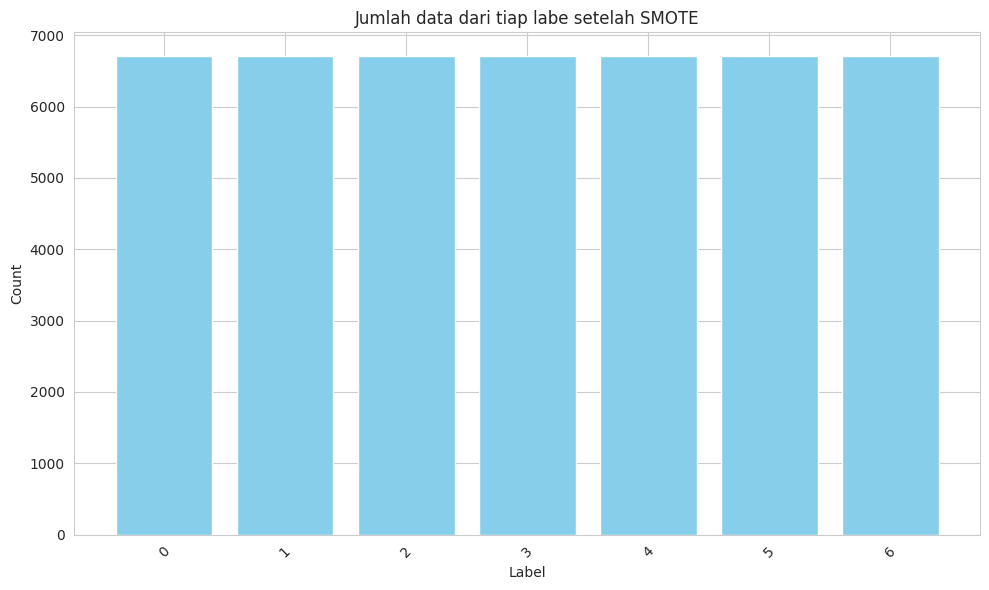

In [ ]:
import matplotlib.pyplot as plt

# Dataframe label_counts_df
label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['Label', 'Count']

# Plotting diagram batang
plt.figure(figsize=(10, 6))
plt.bar(label_counts_df['Label'], label_counts_df['Count'], color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Jumlah data dari tiap labe setelah SMOTE')
plt.xticks(rotation=45)
plt.tight_layout()

# Tampilkan diagram
plt.show()

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(data_reshaped, label, test_size=.30, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=.50, random_state=42, shuffle=True)

In [ ]:
print(f'x_train shape: {x_train.shape}\nx_val shape: {x_val.shape}\nx_test shape: {x_test.shape}')
print('-'*20)
print(f'y_train shape: {y_train.shape}\ny_val shape: {y_val.shape}\ny_test shape: {y_test.shape}')

x_train shape: (32854, 120, 120, 3)
x_val shape: (7040, 120, 120, 3)
x_test shape: (7041, 120, 120, 3)
--------------------
y_train shape: (32854,)
y_val shape: (7040,)
y_test shape: (7041,)


# Model

In [ ]:
# Load the pre-trained DenseNet model without top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [ ]:
history = model.fit(x_train, y_train, epochs=60, batch_size=64, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/60
514/514 [==============================] - 28s 37ms/step - loss: 0.9499 - accuracy: 0.6479 - val_loss: 0.6829 - val_accuracy: 0.7504 - lr: 0.0010
Epoch 2/60
514/514 [==============================] - 14s 27ms/step - loss: 0.6618 - accuracy: 0.7542 - val_loss: 0.5185 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 3/60
514/514 [==============================] - 14s 27ms/step - loss: 0.5581 - accuracy: 0.7931 - val_loss: 0.4554 - val_accuracy: 0.8362 - lr: 0.0010
Epoch 4/60
514/514 [==============================] - 14s 27ms/step - loss: 0.4876 - accuracy: 0.8208 - val_loss: 0.4217 - val_accuracy: 0.8479 - lr: 0.0010
Epoch 5/60
514/514 [==============================] - 14s 27ms/step - loss: 0.4400 - accuracy: 0.8368 - val_loss: 0.3788 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 6/60
514/514 [==============================] - 14s 27ms/step - loss: 0.3976 - accuracy: 0.8557 - val_loss: 0.3572 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 7/60
514/514 [==============================] - 14s 

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

221/221 [==============================] - 6s 18ms/step - loss: 0.2341 - accuracy: 0.9320
Test Accuracy: 0.9319698810577393
Test Loss: 0.2341018170118332


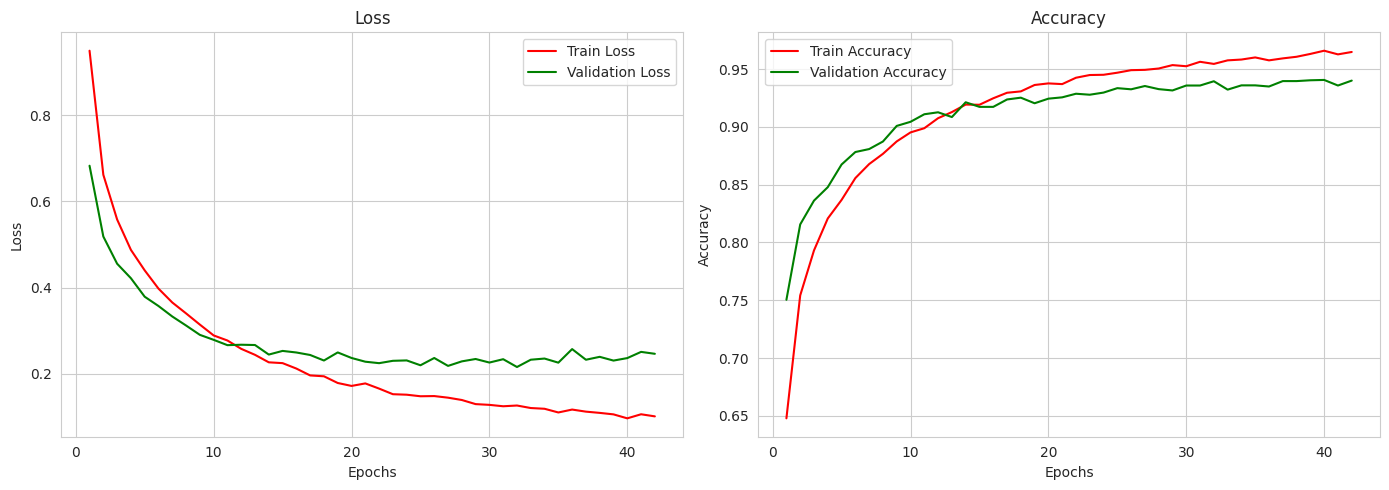

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(x_test)

221/221 [==============================] - 5s 15ms/step


In [ ]:
cm = confusion_matrix(y_test, np.argmax(predictions, axis=1))
cm

array([[ 900,   16,    8,    0,   11,    2,    0],
       [  10,  972,   12,    0,    3,    0,    0],
       [  22,   22,  883,    0,   28,   50,    1],
       [   3,    2,    0, 1066,    1,    3,    0],
       [  19,   16,   30,    3,  878,   52,    0],
       [   7,   17,   39,    8,   92,  841,    1],
       [   0,    0,    1,    0,    0,    0, 1022]])

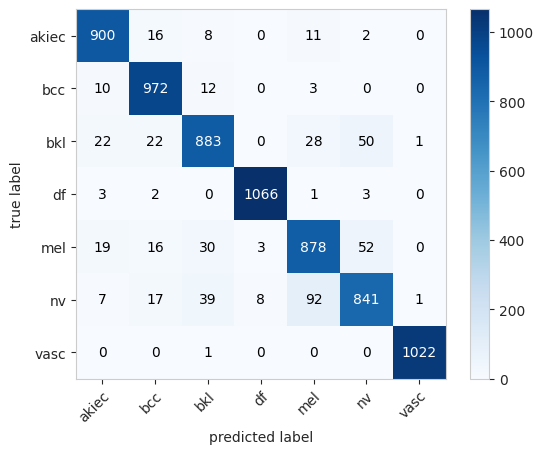

In [ ]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=cm_plot_labels, colorbar=True)
plt.show()

In [ ]:
report = classification_report(y_test, np.argmax(predictions, axis=1), target_names=cm_plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.94      0.96      0.95       937
         bcc       0.93      0.97      0.95       997
         bkl       0.91      0.88      0.89      1006
          df       0.99      0.99      0.99      1075
         mel       0.87      0.88      0.87       998
          nv       0.89      0.84      0.86      1005
        vasc       1.00      1.00      1.00      1023

    accuracy                           0.93      7041
   macro avg       0.93      0.93      0.93      7041
weighted avg       0.93      0.93      0.93      7041



In [ ]:
# Pastikan test set sudah ada
print(f'x_test shape: {x_test.shape}\ny_test shape: {y_test.shape}')

x_test shape: (7041, 120, 120, 3)
y_test shape: (7041,)


In [ ]:
print(y_test[:10])  # Cek 10 label pertama

[3 3 4 5 3 5 2 4 5 1]


In [ ]:
# Cek tipe data y_test
if not isinstance(y_test, np.ndarray):
    y_test = np.array(y_test)

print(type(y_test))  # Harus menunjukkan <class 'numpy.ndarray'>

<class 'numpy.ndarray'>


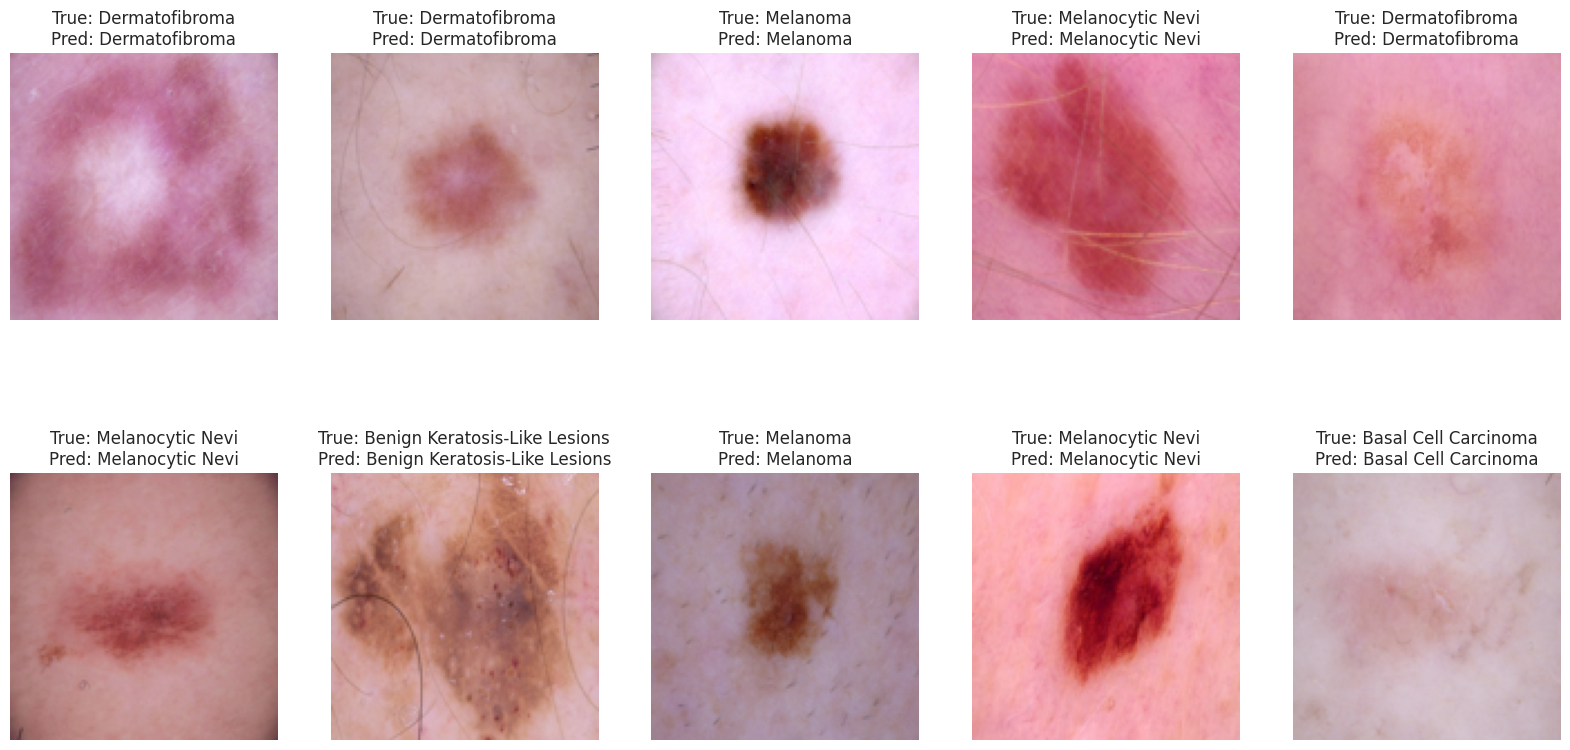

In [ ]:
import matplotlib.pyplot as plt

# Fungsi untuk memplot gambar dengan label prediksi dan sebenarnya
def plot_images(images, true_labels, pred_labels, class_names, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i]
        # Pastikan nilai piksel berada dalam rentang [0, 1]
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        true_label = class_names[true_labels[i]]
        pred_label = class_names[np.argmax(pred_labels[i])]
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.show()

# Daftar nama kelas (sesuaikan dengan urutan kelas di dataset Anda)
class_names = ['Actinic Keratoses', 'Basal Cell Carcinoma', 'Benign Keratosis-Like Lesions', 'Dermatofibroma', 'Melanoma', 'Melanocytic Nevi', 'Vascular Lesions']

# Plot 10 gambar pertama dari test set
plot_images(x_test, y_test, predictions, class_names, num_images=10)

In [ ]:
# save model
model.save('/content/drive/MyDrive/model-skin4-smote.h5')

In [ ]:
# save model weight
model.save_weights('/content/drive/MyDrive/model-weight-skin4-smote.h5')

1/1 [==============================] - 0s 34ms/step


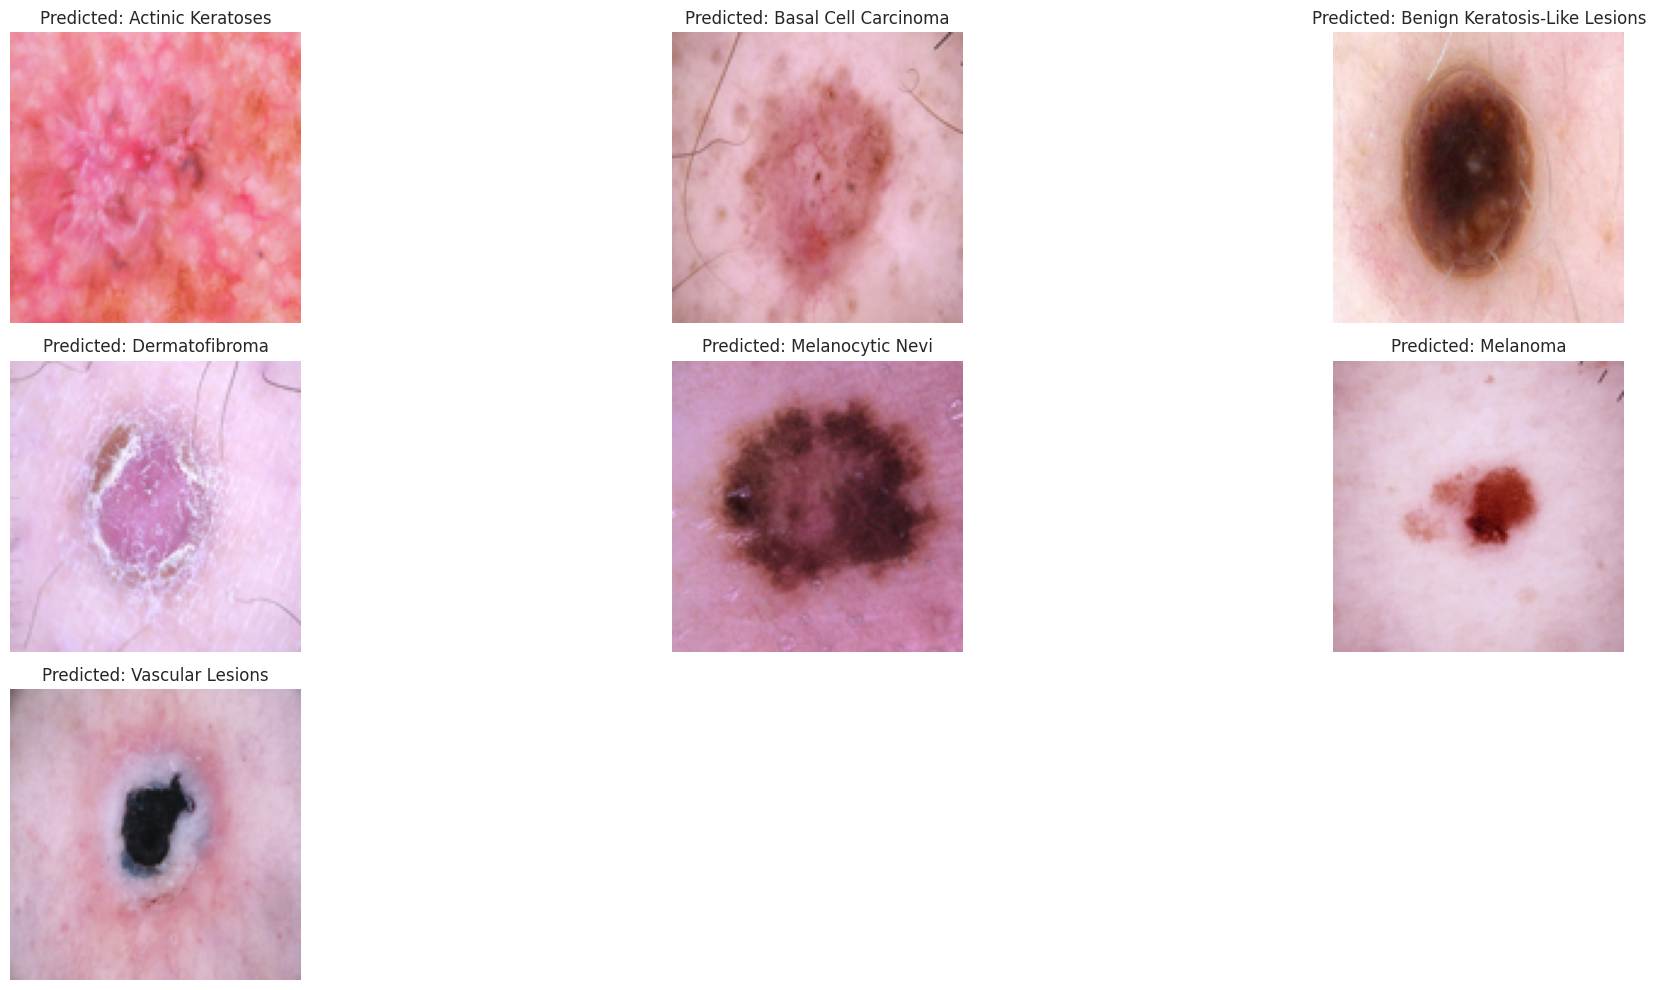

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Muat model yang telah disimpan
model_path = '/content/drive/MyDrive/model-skin4-smote.h5'
model = load_model(model_path)

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(image_path, target_size=(120, 120)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalisasi gambar
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
    return img_array

# List of image paths
image_paths = [
    '/content/drive/MyDrive/data-testing/actinic-keratoses.jpg',
    '/content/drive/MyDrive/data-testing/basal-cell-carcinoma.jpg',
    '/content/drive/MyDrive/data-testing/benign-keratoses-like-lesions.jpg',
    '/content/drive/MyDrive/data-testing/dermatofibroma.jpg',
    '/content/drive/MyDrive/data-testing/melanocytic-nevi.jpg',
    '/content/drive/MyDrive/data-testing/melanoma.jpg',
    '/content/drive/MyDrive/data-testing/vascular-lesions.jpg'
]

# Daftar nama kelas (sesuaikan dengan urutan kelas di dataset Anda)
class_names = ['Actinic Keratoses', 'Basal Cell Carcinoma', 'Benign Keratosis-Like Lesions', 'Dermatofibroma','Melanoma', 'Melanocytic Nevi', 'Vascular Lesions']

# Atur jumlah kolom
num_cols = 3

# Buat plot untuk memvisualisasikan prediksi
plt.figure(figsize=(20, 10))

for i, image_path in enumerate(image_paths):
    # Muat dan preproses gambar
    image = load_and_preprocess_image(image_path)

    # Lakukan prediksi menggunakan model yang dimuat
    prediction = model.predict(image)

    # Ambil label prediksi
    predicted_label = class_names[np.argmax(prediction)]

    # Plot gambar yang dimuat
    plt.subplot(len(image_paths) // num_cols + 1, num_cols, i + 1)
    plt.imshow(np.squeeze(image))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 2s 2s/step
Image: /content/drive/MyDrive/data-testing/actinic-keratoses.jpg
Predicted class: Actinic Keratoses
Confidence: 99.9992847442627 %
---


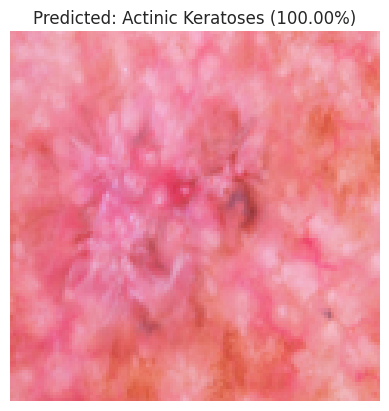

1/1 [==============================] - 0s 34ms/step
Image: /content/drive/MyDrive/data-testing/basal-cell-carcinoma.jpg
Predicted class: Basal Cell Carcinoma
Confidence: 99.99938011169434 %
---


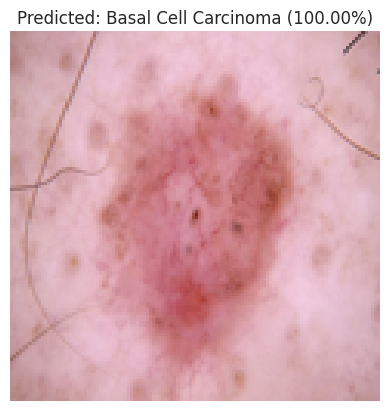

1/1 [==============================] - 0s 33ms/step
Image: /content/drive/MyDrive/data-testing/benign-keratoses-like-lesions.jpg
Predicted class: Benign Keratosis-Like Lesions
Confidence: 99.99996423721313 %
---


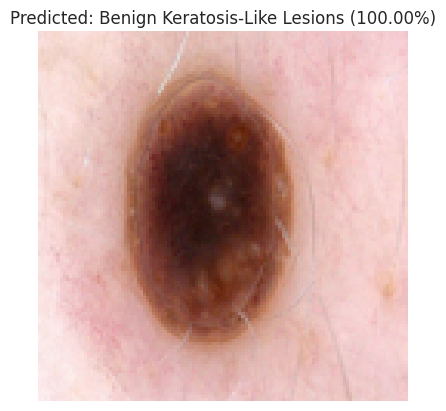

1/1 [==============================] - 0s 35ms/step
Image: /content/drive/MyDrive/data-testing/dermatofibroma.jpg
Predicted class: Dermatofibroma
Confidence: 99.96458292007446 %
---


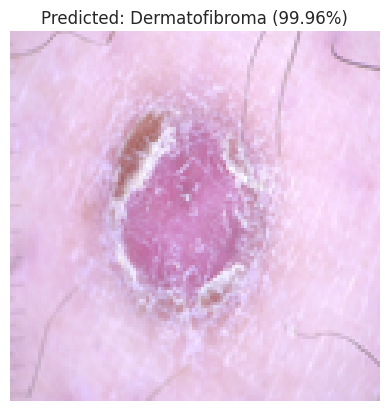

1/1 [==============================] - 0s 36ms/step
Image: /content/drive/MyDrive/data-testing/melanocytic-nevi.jpg
Predicted class: Melanocytic Nevi
Confidence: 98.69116544723511 %
---


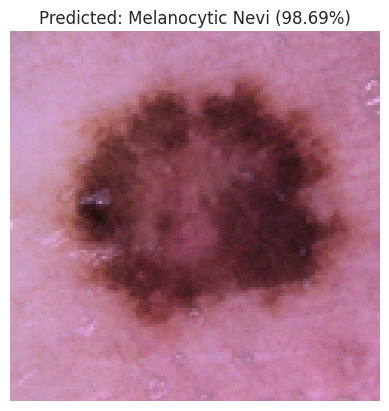

1/1 [==============================] - 0s 32ms/step
Image: /content/drive/MyDrive/data-testing/melanoma.jpg
Predicted class: Melanoma
Confidence: 94.22667622566223 %
---


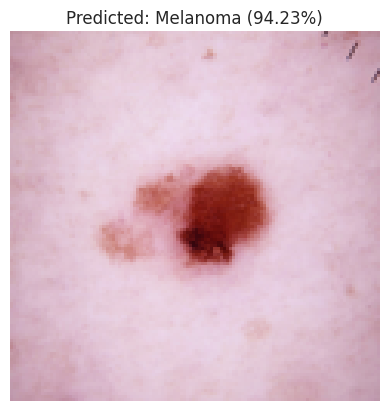

1/1 [==============================] - 0s 32ms/step
Image: /content/drive/MyDrive/data-testing/vascular-lesions.jpg
Predicted class: Vascular Lesions
Confidence: 100.0 %
---


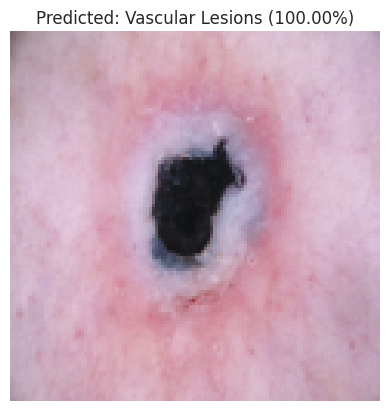

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Muat model yang telah disimpan
model_path = '/content/drive/MyDrive/model-skin4-smote.h5'
model = load_model(model_path)

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(image_path, target_size=(120, 120)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalisasi gambar
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
    return img_array

# List of image paths
image_paths = [
    '/content/drive/MyDrive/data-testing/actinic-keratoses.jpg',
    '/content/drive/MyDrive/data-testing/basal-cell-carcinoma.jpg',
    '/content/drive/MyDrive/data-testing/benign-keratoses-like-lesions.jpg',
    '/content/drive/MyDrive/data-testing/dermatofibroma.jpg',
    '/content/drive/MyDrive/data-testing/melanocytic-nevi.jpg',
    '/content/drive/MyDrive/data-testing/melanoma.jpg',
    '/content/drive/MyDrive/data-testing/vascular-lesions.jpg'
]

# Daftar nama kelas (sesuaikan dengan urutan kelas di dataset Anda)
class_names = ['Actinic Keratoses', 'Basal Cell Carcinoma', 'Benign Keratosis-Like Lesions', 'Dermatofibroma','Melanoma', 'Melanocytic Nevi', 'Vascular Lesions']

# Loop melalui image paths
for image_path in image_paths:
    # Muat dan preproses gambar
    img_array = load_and_preprocess_image(image_path)

    # Lakukan prediksi menggunakan model yang dimuat
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100  # Confidence dalam persentase

    # Cetak hasil prediksi
    print('Image:', image_path)
    print('Predicted class:', predicted_class)
    print('Confidence:', confidence, '%')
    print('---')

    # Visualisasikan gambar dan prediksi
    plt.figure()
    plt.imshow(np.squeeze(img_array))
    plt.title(f'Predicted: {predicted_class} ({confidence:.2f}%)')
    plt.axis('off')
    plt.show()

In [ ]:
# Loop melalui image paths
for image_path in image_paths:
    # Muat dan preproses gambar
    img_array = load_and_preprocess_image(image_path)

    # Lakukan prediksi menggunakan model yang dimuat
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100  # Confidence dalam persentase

    # Cetak hasil prediksi
    print('Image:', image_path)
    print('Predicted class:', predicted_class)
    print('Confidence:', confidence, '%')

1/1 [==============================] - 0s 33ms/step
Image: /content/drive/MyDrive/data-testing/actinic-keratoses.jpg
Predicted class: Actinic Keratoses
Confidence: 99.9992847442627 %
1/1 [==============================] - 0s 30ms/step
Image: /content/drive/MyDrive/data-testing/basal-cell-carcinoma.jpg
Predicted class: Basal Cell Carcinoma
Confidence: 99.99938011169434 %
1/1 [==============================] - 0s 31ms/step
Image: /content/drive/MyDrive/data-testing/benign-keratoses-like-lesions.jpg
Predicted class: Benign Keratosis-Like Lesions
Confidence: 99.99996423721313 %
1/1 [==============================] - 0s 32ms/step
Image: /content/drive/MyDrive/data-testing/dermatofibroma.jpg
Predicted class: Dermatofibroma
Confidence: 99.96458292007446 %
1/1 [==============================] - 0s 31ms/step
Image: /content/drive/MyDrive/data-testing/melanocytic-nevi.jpg
Predicted class: Melanocytic Nevi
Confidence: 98.69116544723511 %
1/1 [==============================] - 0s 30ms/step
Image: 